# Statistical Algos

## Notebook's Environment

In [1]:
INSTALL_DEPS = False
if INSTALL_DEPS:
  %pip install matplotlib==3.8.3
  %pip installnumpy==1.26.4
  %pip installpandas==2.2.1
  %pip installpandas_market_calendars==4.4.0
  %pip installpytz==2024.1
  %pip installscipy==1.12.0
  %pip installta==0.11.0
  %pip installyfinance==0.2.37

!python --version

Python 3.11.8


## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

running localhost!


# Instruments

In [3]:
from constants import *

TARGET_FUT, INTERVAL

('ZC', '15m')

## Data Load

In [4]:
import pandas as pd
import numpy as np

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)
print(futs_df.columns)
futs_df.head(2)

./data/\futures_15m.csv
(9494, 184)
Index(['10Y_Open', '10Y_High', '10Y_Low', '10Y_Close', '10Y_Volume',
       '10Y_Barcount', '10Y_Average', '10Y_Spread', '2Y_Open', '2Y_High',
       ...
       'ZS_Average', 'ZS_Spread', 'ZW_Open', 'ZW_High', 'ZW_Low', 'ZW_Close',
       'ZW_Volume', 'ZW_Barcount', 'ZW_Average', 'ZW_Spread'],
      dtype='object', length=184)


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2Y_Open,2Y_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29 15:30:00+00:00,3.883,3.883,3.86,3.860,95.0,48.0,3.8709,0.023,4.184,4.184,...,1308.375,5.0,630.25,632.00,626.25,629.50,3081.0,1133.0,628.7,5.75
2023-12-29 15:45:00+00:00,3.860,3.878,3.86,3.875,18.0,14.0,3.8722,0.018,4.184,4.184,...,1304.325,3.5,629.75,631.25,628.75,629.25,996.0,468.0,630.1,2.50


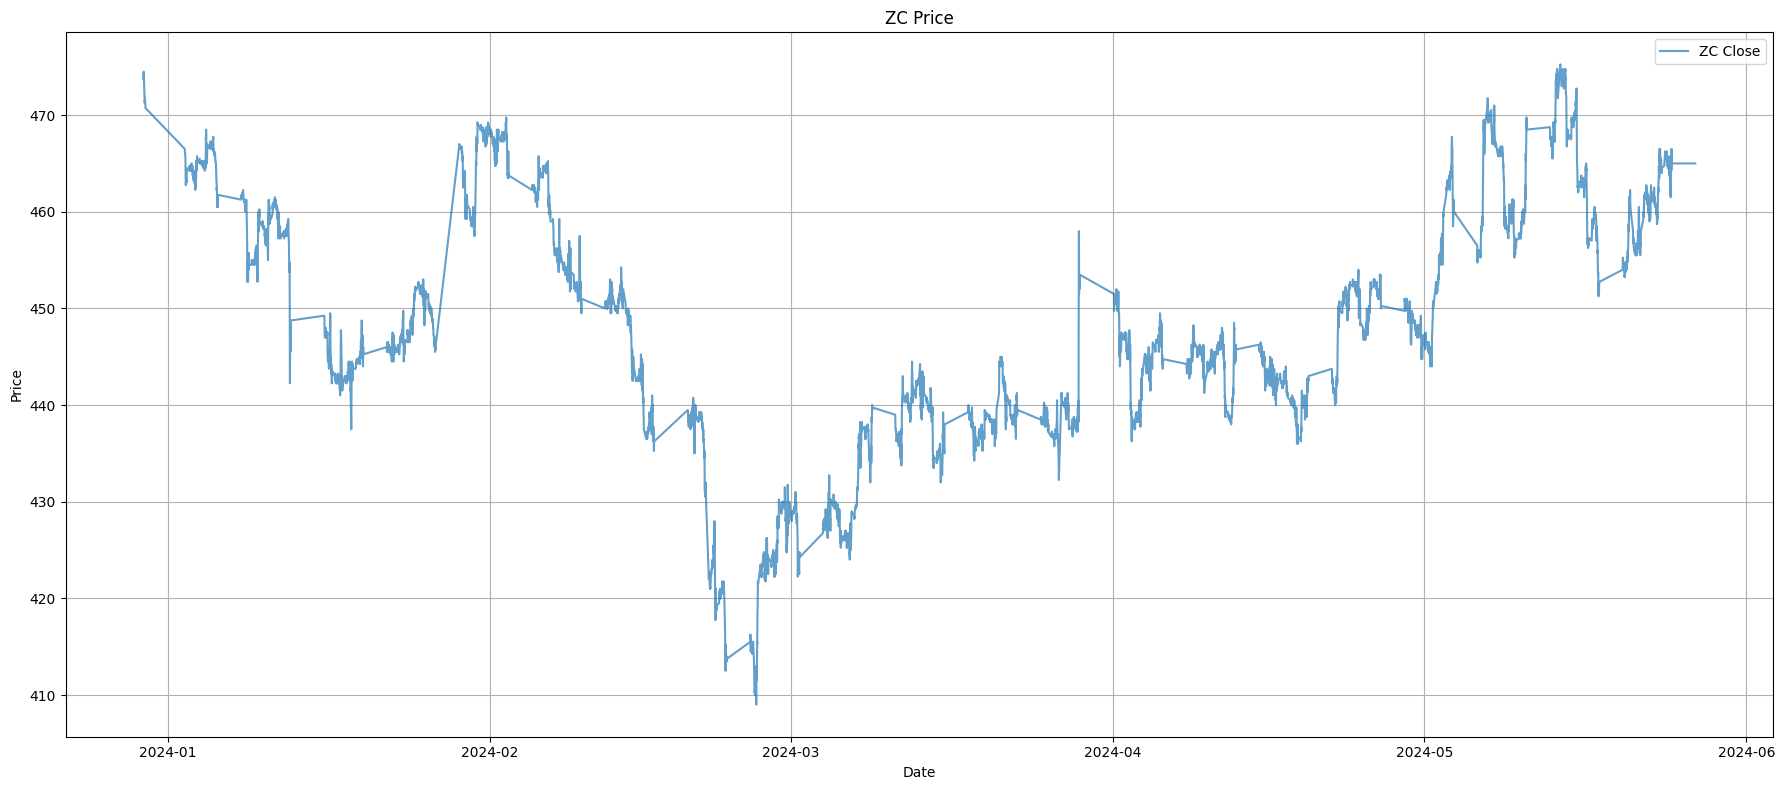

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 8))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
target_fut_df = futs_df[[f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume"]]
target_fut_df.tail(5)

,ZC_Close,ZC_Volume
Date,,
2024-05-27 00:45:00+00:00,465.0,4086.0
2024-05-27 01:00:00+00:00,465.0,4086.0
2024-05-27 01:15:00+00:00,465.0,4086.0
2024-05-27 01:30:00+00:00,465.0,4086.0
2024-05-27 01:45:00+00:00,465.0,4086.0


In [7]:
from quant_equations import get_ou, get_annualized_factor, calc_annualized_sharpe, deflated_sharpe_ratio, modulate_std

HALF_LIFE, HURST = get_ou(target_fut_df, f"{TARGET_FUT}_Close")

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

Half-Life: 597
Hurst: -0.5452973413693386


# Kalman Filter

The Kalman filter consists of states, observations, and transitions.

$$
X_t = H_t Z_t + V_t
$$

$$
Z_t = F_{t-1} Z_{t-1} + G_{t-1} U_{t-1} + W_{t-1}
$$

- $ Z_t $ is the unobservable state, mapped by $ H_t $ to $ X_t $, representing the internal hidden states.
- $ X_t $ is the price.
- $ U_t $ are the control parameters, which are 0 in this case. $ G_t $ links $ U_t $ to $ Z_t $, which is also 0.
- $ F_{t-1} $ is the state transition matrix.
- $ W_t $ and $ V_t $ are the noise terms with covariance matrices $ Q_t $ and $ R_t $, respectively.

The model equations:

1. **Prediction of the Error Covariance:**
$$
P_t = F_{t-1} P_{t-1}^+ F_{t-1}^T + Q_{t-1}
$$
   - Predicts the new error covariance $ P_t $, representing the accuracy of the next prediction.
   - $ Q_{t-1} $ is the process noise covariance.
   - $ F_{t-1} $ is the state transition matrix.
   - $ P_{t-1} $ is the previous error covariance.

2. **Update of the Error Covariance:**
$$
P_t^+ = (I - K_t H_t) P_t (I - K_t H_t)^T + K_t R_t K_t^T
$$
   - Updates the error covariance.
   - $ P_t^+ $ is the new level of uncertainty.
   - $ K_t $ is the Kalman gain.
   - $ H_t $ is the observation matrix.
   - $ R_t $ is the observation noise covariance.
   - $ I $ is the identity matrix.

3. **Kalman Gain:**
$$
K_t = P_t H_t^T (H_t P_t H_t^T + R_t)^{-1}
$$
   - The gain matrix that determines the correction applied to the prediction.
   - A small gain indicates low uncertainty in the observation $ X_t $.

4. **State Prediction:**
$$
Z_t^- = F_{t-1} Z_{t-1}^+ + G_{t-1} U_{t-1}
$$
   - Predicts the next state from the previous corrected state $ Z_{t-1}^+ $, using the state transition matrix $ F_{t-1} $.
   - $ G_{t-1} U_{t-1} $ represents the control input, which is 0 in this case.

5. **State Update:**
$$
Z_t^+ = Z_t^- + K_t (X_t - H_t Z_t^-) = Z_t^- (1 - K_t H_t) + K_t X_t
$$
   - Updates the state $ Z_t^+ $ after incorporating the new observation $ X_t $.
   - $ X_t - H_t Z_t^- $ is the residual (or innovation), representing the difference between the observed and predicted values.


## Kalman no-lookback MA


$$
y(t) = m(t) + \epsilon(t), \quad \text{("Measurement")} 
$$

$$
m(t) = m(t-1) + \omega(t-1). \quad \text{("State transition")}
$$



$$
m(t \mid t) = m(t \mid t-1) + K(t) (y(t) - m(t \mid t-1)). \quad \text{("State update")}
$$



Variance of the Forecast Error
$$
Q(t) = \text{var}(m(t)) + V_{\epsilon}. \tag{3.17}
$$


The **Kalman gain** is
$$
K(t) = \frac{R(t \mid t-1)}{R(t \mid t-1) + V_{\epsilon}}, \tag{3.18}
$$


and the state variance update is

$$
R(t \mid t) = (1 - K(t)) R(t \mid t-1). \tag{3.19}
$$

Uncertainty:
$$
V_{\epsilon} = R(t \mid t-1) \left( \frac{\tau}{T_{\text{max}} - 1} \right) \tag{3.20}
$$

In [8]:
from signals import signal_kf_bollinger_bands


window = abs(HALF_LIFE)
bb_df = signal_kf_bollinger_bands(target_fut_df, f"{TARGET_FUT}_Close", f"{TARGET_FUT}_Volume", std_factor=modulate_std (HURST))
spread = bb_df["%B"].bfill().ffill()
volumes = target_fut_df[f"{TARGET_FUT}_Volume"].to_numpy()
prices = target_fut_df[f"{TARGET_FUT}_Close"].to_numpy()

assert not np.isnan(spread).any() and not np.isnan(volumes).any()

bb_df.tail(5)

signal_kf_bollinger_bands: 100%|██████████| 9494/9494 [00:03<00:00, 2974.48it/s]


,ZC_Close,ZC_Volume,Tmax,V_e,MA,SD,U,L,%B
Date,,,,,,,,,
2024-05-27 00:45:00+00:00,465.0,4086.0,210.960688,19.368537,464.782256,1.043776,467.415335,462.149177,0.541348
2024-05-27 01:00:00+00:00,465.0,4086.0,212.873822,19.194469,464.794616,1.043820,467.427808,462.161424,0.538999
2024-05-27 01:15:00+00:00,465.0,4086.0,214.868388,19.016292,464.806378,1.043582,467.438970,462.173787,0.536774
2024-05-27 01:30:00+00:00,465.0,4086.0,216.944384,18.834320,464.817563,1.043083,467.448894,462.186233,0.534666
2024-05-27 01:45:00+00:00,465.0,4086.0,219.101812,18.648865,464.828192,1.042339,467.457648,462.198736,0.532670


## Visualize KF BB

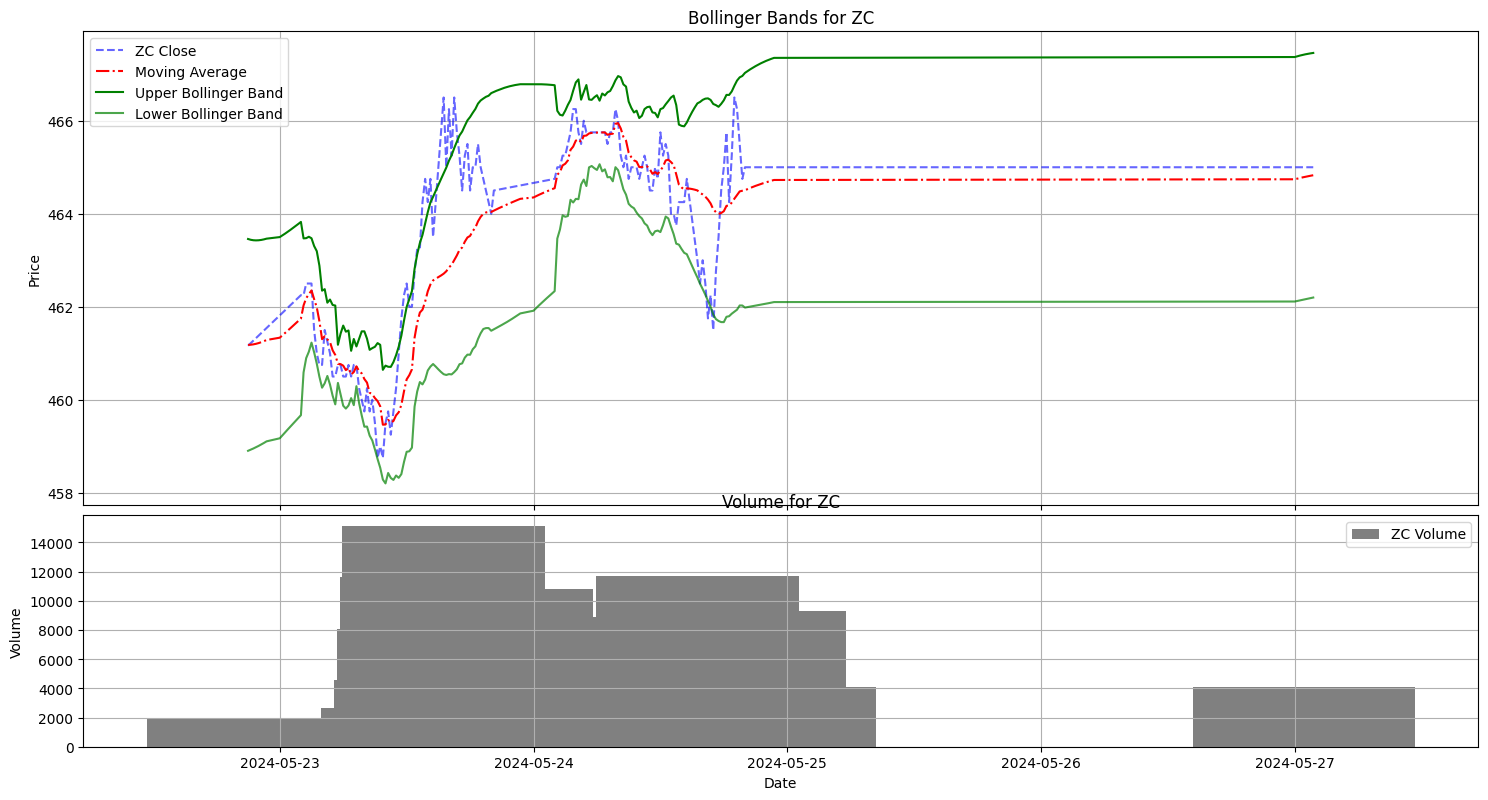

In [9]:
plt.figure(figsize=(18, 14))

# To make the plots easier to read
ZOOM = 200
bb_df = bb_df.tail(ZOOM)

# Plot for price and Bollinger Bands
ax1 = plt.subplot2grid((18, 1), (0, 0), rowspan=8, colspan=1)
ax1.plot(bb_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', color='blue', alpha=0.6, linestyle='--')
ax1.plot(bb_df['MA'], label='Moving Average', color='red', linestyle='-.')
ax1.plot(bb_df['U'], label='Upper Bollinger Band', color='green')
ax1.plot(bb_df['L'], label='Lower Bollinger Band', color='green', alpha=0.7)
ax1.set_title(f'Bollinger Bands for {TARGET_FUT}')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

# Plot for volume
ax2 = plt.subplot2grid((18, 1), (8, 0), rowspan=4, colspan=1, sharex=ax1)
ax2.bar(bb_df.index, bb_df[f'{TARGET_FUT}_Volume'], label=f'{TARGET_FUT} Volume', color='grey')
ax2.set_title(f'Volume for {TARGET_FUT}')
ax2.set_xlabel('Date')
ax2.set_ylabel('Volume')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Backtest

In [10]:
from tqdm import tqdm
from signals import param_search_kf_bbs

stats_df = param_search_kf_bbs(futs_df, f'{TARGET_FUT}_Close', f'{TARGET_FUT}_Volume', hurst=HURST, period=INTERVAL)
cumret_df= stats_df[stats_df["Metric"] == "Cumulative Returns"]

BEST_T_MAX = cumret_df["T_max"].values[0]
BEST_STD_FACTOR = cumret_df["Standard_Factor"].values[0]

cumret_df.drop(columns=["Rets"])

param_search_bbs: 100%|██████████| 9/9 [01:32<00:00, 10.25s/it]


,T_max,Standard_Factor,stoploss_pct,Cumulative_Returns,Max Ret,Max Loss,Variance,STD,Max_Drawdown,Drawdown_Length,Sharpe,Trades_Count,Trades_per_Interval,Trading_Intervals,Rets_Skew,Rets_Kurt,Metric
1,0.1,2.052265,0.9,0.011568,0.00978,-0.033811,8.442417e-07,0.000919,-0.083782,2181,0.258002,228,0.024015,9494,-13.610789,374.870693,Cumulative Returns


# KF

$$ x(t+1) = x(t) + \omega(t)$$ 

where $ x(t) $ is the stock close price at time $ t $ with a normal distribution $ N(\mu_t, P_t) $ and $ \omega(t) $ is the process model distributed as $ N(0, Q_t) $. 

The spread between consecutive close spread is a white noise with a time varying variance.

The measurement $ z(t) $ would be the observed daily close price. 
Because there is no uncertainty, we can interpret the measurement noise, $ N(0, R_t) $, as the belief that the observed price is meaningful. If the observed price has a large impact on future spread, i.e., if $R_t$ is small, then the Kalman filter would update our prediction to be closer to the observed price. Conversely, if we are not sure, i.e., if $ R_t $ is large, then the observed price won't be used to augment our prediction. 

Assuming that a close price with a large trading volume compared to the previous day is more likely to affect the next day's price:

$$
R_t = P_t \ast \frac{V_{t-1}}{\min(V_{t-1}, V_t)}
$$

where $ V_t $ is the daily trading volume at day $ t $.(Sinclair, 2010).

Init:
- $\mu_0 = z(0)$: The last close price on the first daily.
- $P_0$: The variance of  the least interval.
- Qt of process model $w(t)$ as $Q_0 = \frac{\sigma}{1-\sigma}$, where $\sigma$ is $10^{-4}$ (Chan. 2013)

https://thescipub.com/pdf/jcssp.2023.739.748.pdf

For a system with position, velocity, and acceleration, the state transition matrix can be derived from the kinematic equations.
Assuming a discrete-time system with constant time step $ \Delta t $:
- Position (price) $ x_t $
- Velocity (speed) $ v_t $
- Acceleration $ a_t $

The state vector $ Z_t $ is:

$$
Z_t = \begin{bmatrix} x_t \\ v_t \\ a_t \end{bmatrix}
$$

The kinematic equations for constant acceleration are:

$$
x_{t+1} = x_t + v_t \Delta t + \frac{1}{2} a_t \Delta t^2
$$

$$
v_{t+1} = v_t + a_t \Delta t
$$

$$
a_{t+1} = a_t \quad \text{(assuming acceleration remains constant over the time step)}
$$

These equations can be represented in matrix form as:

$$
\begin{bmatrix} x_{t+1} \\ v_{t+1} \\ a_{t+1} \end{bmatrix} = \begin{bmatrix} 1 & \Delta t & \frac{1}{2} \Delta t^2 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x_t \\ v_t \\ a_t \end{bmatrix}
$$

Thus, the state transition matrix $ F $ is:

$$
F = \begin{bmatrix} 1 & \Delta t & \frac{1}{2} \Delta t^2 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix}
$$

The observation matrix $ H $ maps the state vector $ Z_t $ to the observation $ X_t $.

Since the \%B measure directly relates to the position component of the state vector, the observation matrix $ H $ is:
$$
H = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix}
$$

This means that the observed \%B measure is a direct observation of the position without direct observation of velocity or acceleration.


In [11]:
from sklearn.metrics import mean_squared_error
from signals import signal_kf

bb_df = signal_kf_bollinger_bands(target_fut_df,
                                  f"{TARGET_FUT}_Close",
                                  f"{TARGET_FUT}_Volume",
                                  std_factor=BEST_STD_FACTOR,
                                  t_max=BEST_T_MAX)
spread = bb_df["%B"].bfill().ffill()
assert not np.isnan(spread).any()

results = signal_kf(spread, volumes, prices)
mse = mean_squared_error(results['X'], results['Filtered_X'])
print(f'MSE {mse}')
results.tail(5)

100%|██████████| 8545/8545 [00:03<00:00, 2659.10it/s]

MSE 0.005975253073547711


,Close,X,Z1,Z2,Filtered_X,Uncertainty,Residuals,KG_X,KG_Z1,KG_Z2
Date,,,,,,,,,,
2024-05-27 00:45:00+00:00,465.0,0.550825,-0.002938,0.000184,0.550832,0.000079,-0.000007,0.479115,0.424217,0.156934
2024-05-27 01:00:00+00:00,465.0,0.547938,-0.002794,0.000169,0.547941,0.000073,-0.000004,0.480107,0.428400,0.159424
2024-05-27 01:15:00+00:00,465.0,0.545203,-0.002649,0.000160,0.545205,0.000068,-0.000002,0.481031,0.432297,0.161749
2024-05-27 01:30:00+00:00,465.0,0.542612,-0.002509,0.000152,0.542613,0.000063,-0.000002,0.481890,0.435929,0.163922
2024-05-27 01:45:00+00:00,465.0,0.540158,-0.002376,0.000145,0.540159,0.000059,-0.000002,0.482691,0.439317,0.165953


## Visuals

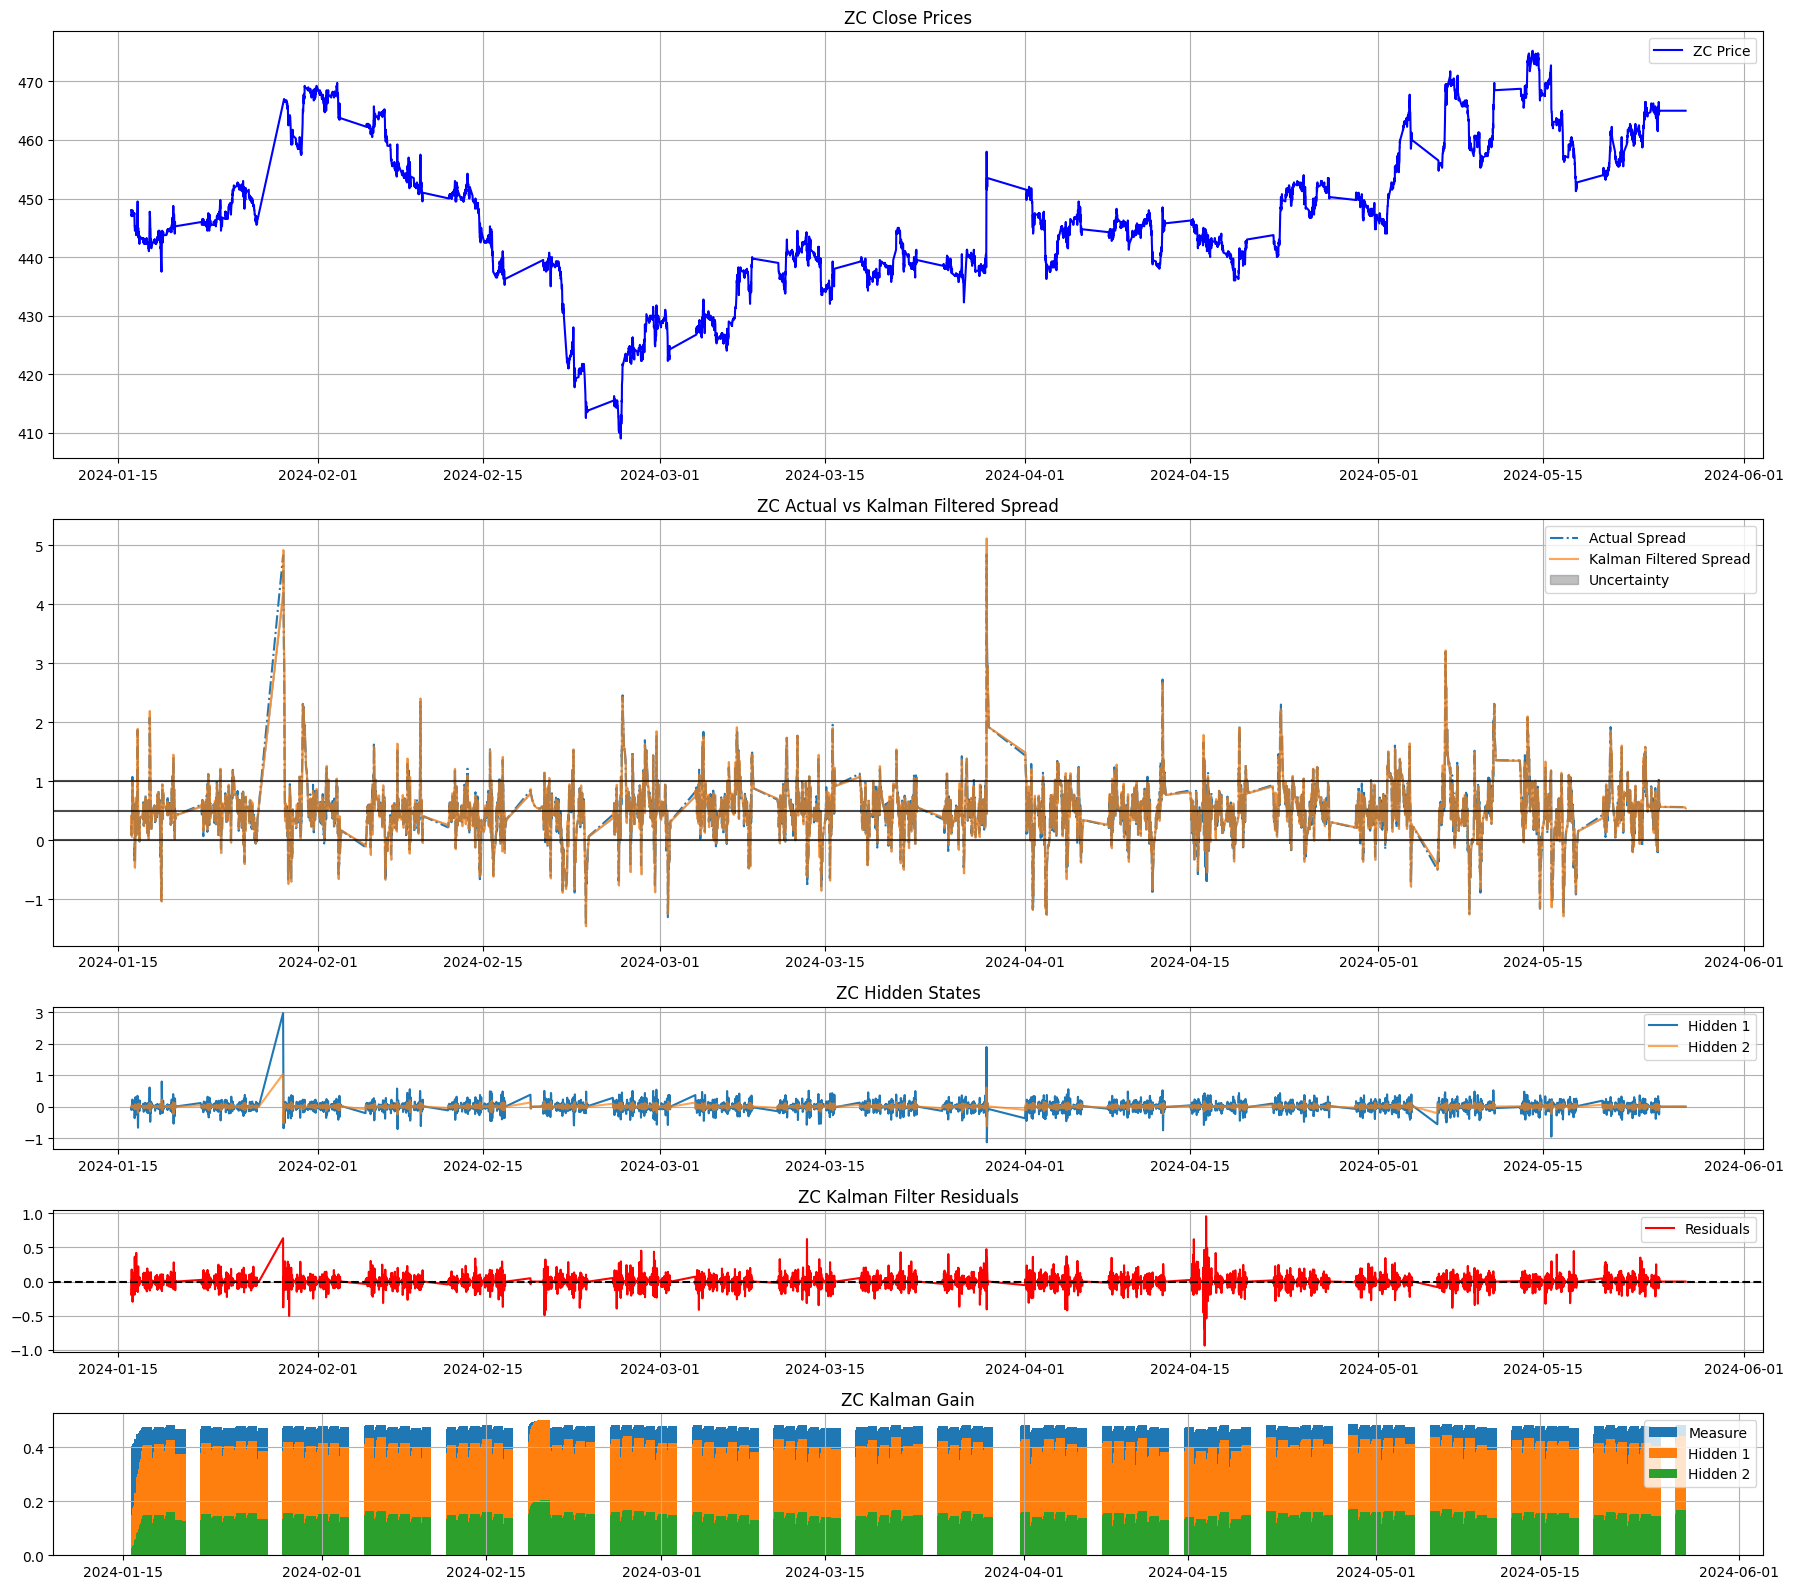

In [12]:
fig, axs = plt.subplots(5, gridspec_kw={'height_ratios': [3, 3, 1, 1, 1]}, figsize=(18, 16))

# Plot the future's close prices
axs[0].plot(results['Close'].index, results['Close'], label=f'{TARGET_FUT} Price', color='blue')
axs[0].set_title(f'{TARGET_FUT} Close Prices')
axs[0].grid(True)
axs[0].legend()

# Plot the actual vs filtered spread with uncertainty tunnel
axs[1].plot(results.index, results['X'], label='Actual Spread', linestyle="-.")
axs[1].plot(results.index, results['Filtered_X'], label='Kalman Filtered Spread', alpha=0.7)
axs[1].fill_between(results.index,
                    results['Filtered_X'] - results['Uncertainty'],
                    results['Filtered_X'] + results['Uncertainty'],
                    label='Uncertainty', color="gray", alpha=0.5)
axs[1].axhline(y=1., color='black', alpha=0.7)
axs[1].axhline(y=0.5, color='black', alpha=0.7)
axs[1].axhline(y=0., color='black', alpha=0.7)
axs[1].set_title(f'{TARGET_FUT} Actual vs Kalman Filtered Spread')
axs[1].legend()
axs[1].grid(True)
# axs[1].set_ylim(-0.5,2)

# Plot the residuals
axs[2].plot(results.index, results['Z1'], label='Hidden 1')
axs[2].plot(results.index, results['Z2'], label='Hidden 2', alpha=0.7)
axs[2].set_title(f'{TARGET_FUT} Hidden States')
axs[2].grid(True)
axs[2].legend()

# Plot the residuals
axs[3].plot(results.index, results['Residuals'], label='Residuals', color='red')
axs[3].set_title(f'{TARGET_FUT} Kalman Filter Residuals')
axs[3].axhline(y=0, color='black', linestyle='--')
axs[3].grid(True)
axs[3].legend()

# Kalman Gain
axs[4].bar(results.index, results['KG_X'], label='Measure')
axs[4].bar(results.index, results['KG_Z1'], label='Hidden 1')
axs[4].bar(results.index, results['KG_Z2'], label='Hidden 2')
axs[4].set_title(f'{TARGET_FUT} Kalman Gain')
axs[4].grid(True)
axs[4].legend()

plt.tight_layout()
plt.show()

# Backtests

In [13]:
from signals import kalman_backtest

df, stats_df = kalman_backtest(spread, volumes, prices, period=INTERVAL)
stats_df.drop(columns=["Rets"])

100%|██████████| 8545/8545 [00:03<00:00, 2679.80it/s]
kalman_backtest: 8545it [00:01, 6837.92it/s]


,Thresholds,Stoploss_pct,Cumulative_Returns,Max Ret,Max Loss,Variance,STD,Max_Drawdown,Drawdown_Length,Sharpe,Trades_Count,Trades_per_Interval,Trading_Intervals,Rets_Skew,Rets_Kurt
0,"[0, 0.5, 1]",0.9,0.033257,0.008219,-0.031869,8.691632e-07,0.000932,-0.089647,2158,0.470492,202,0.02364,8545,-13.510486,375.059199
